# 导入工具

In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
%matplotlib inline

import jieba
import json
from gensim.models import FastText, Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from scipy.spatial.distance import cosine
import networkx as nx

from functools import reduce, partial
from collections import Counter

In [2]:
pre_trained_wiki_model = r"D:\Github\NLP\Projects\data\trained_models\wiki_ltp_model.model"
wiki_model = Word2Vec.load(pre_trained_wiki_model)

In [70]:
raw_df = pd.read_csv('data/sqlResult_1558435.csv', encoding='gb18030')

## 预处理函数

In [2]:
def clean_df_pipe(raw_data):
    df = raw_data.copy()
    df.dropna(subset=['content'],inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.id = df.index
    return df

In [89]:
def string_pipe(string):
    string = re.sub(r'[\r\n\u3000]', ' ', string)
    string = re.sub(r'[\\/\（\）]', ' ', string)
    string = ' '.join(jieba.cut(string))
    string = re.sub(r'\s+', ' ', string)
    return string

In [90]:
df = clean_df_pipe(raw_df)

In [91]:
df.tail(2)

,id,author,source,content,feature,title,url
87052,87052,夏文辉,新华社,\n\n2017年5月25日，在美国马萨诸塞州剑桥市，哈佛大学毕业生在毕业典礼上欢呼。（新华...,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",哈佛大学为何取消这些新生入选资格？,http://home.xinhua-news.com/gdsdetailxhsnew/22...
87053,87053,王子江 张寒,新华社,新华社德国杜塞尔多夫６月６日电题：乒乓女球迷 \n 新华社记者王子江、张寒\n 熊老...,"{""type"":""体育"",""site"":""新华社"",""url"":""http://home.x...",（体育）题：乒乓女球迷,http://home.xinhua-news.com/gdsdetailxhsnew/22...


In [92]:
df_clean = pd.DataFrame()
df_clean['content'] = df.content.apply(string_pipe)
df_clean['title'] = df.title
# df_clean['summary'] = df.feature.apply(lambda x: json.loads(x)['summary'])
df_clean.head()

,content,title
0,此外 ， 自 本周 6 月 12 日 起 ， 除 小米 手机 6 等 15 款 机型 外 ，...,小米MIUI 9首批机型曝光：共计15款
1,骁龙 835 作为 唯一 通过 Windows 10 桌面 平台 认证 的 ARM 处理器 ...,骁龙835在Windows 10上的性能表现有望改善
2,此前 的 一加 3T 搭载 的 是 3400mAh 电池 ， DashCharge 快充 规...,一加手机5细节曝光：3300mAh、充半小时用1天
3,这是 6 月 18 日 在 葡萄牙 中部 大 佩德罗 冈 地区 拍摄 的 被 森林 大火 烧...,葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）
4,原 标题 ： 44 岁 女子 跑 深圳 约会 网友 被 拒 ， 暴雨 中 裸身 奔走 … ...,44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随


In [93]:
df_clean.to_csv('data/cleaned_data.csv', encoding='utf-8')

---

In [10]:
df_clean = pd.read_csv('data/cleaned_data.csv', encoding='utf-8', index_col=0)

## 词向量

In [8]:
#with open('data/corpus.txt', 'w', encoding='utf-8') as f:
    for content in df_clean.content:
        f.write(content)

In [106]:
model = FastText(LineSentence('data/corpus.txt'), window=5, size=40, iter=10, min_count=1)

In [107]:
# 保存模型
model.save('data/fasttext.model')

In [108]:
# 只保存词向量
model.wv.save('data/fasttest.kv')

In [114]:
model.wv.most_similar('电池')

[('干电池', 0.98030686378479),
 ('废电池', 0.9665732383728027),
 ('蓄电池', 0.9643412828445435),
 ('酸蓄电池', 0.9421657919883728),
 ('燃料电池', 0.9406098127365112),
 ('锂电池', 0.9249415993690491),
 ('电池容量', 0.9161360859870911),
 ('充电电池', 0.9133886694908142),
 ('光电池', 0.9111385345458984),
 ('电池组', 0.9109917879104614)]

In [4]:
wv_from_kv = KeyedVectors.load('data/fasttest.kv')

In [5]:
wv_from_kv.most_similar('总统')

[('陈冠辛', 0.9700720310211182),
 ('下任总统', 0.9145525097846985),
 ('代总统', 0.9022562503814697),
 ('总统府', 0.8381916880607605),
 ('俄总统', 0.8303344249725342),
 ('内阁总理', 0.8290834426879883),
 ('特梅尔能', 0.8250315189361572),
 ('总统大选', 0.8212908506393433),
 ('代总理', 0.8200234174728394),
 ('下议院', 0.8171863555908203)]

In [11]:
tokens = [word for doc in df_clean.content for word in doc.split()]

In [12]:
tokens[:10]

['此外', '，', '自', '本周', '6', '月', '12', '日', '起', '，']

## 词频统计

In [13]:
token_counter = Counter(tokens)

In [14]:
word_to_freq = {word:round(count/len(token_counter), 9) for word, count 
               in token_counter.items()}

In [15]:
word_to_freq_sorted = sorted(word_to_freq.items(), key=lambda x:x[1], reverse=1)
plot_length = 100
y = [value for _, value in word_to_freq_sorted]

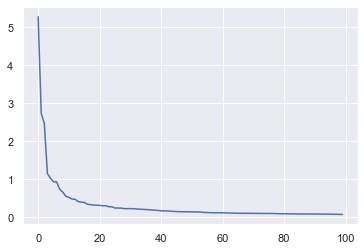

In [16]:
plt.plot(range(plot_length), y[:plot_length])
plt.show()

## PageRank

In [39]:
def pagerank(M, num_iteration=100, alpha=.85):
    N = M.shape[1]
    V = np.random.rand(N, 1)
    V = V / np.linalg.norm(V,1)
    iteration = 0
    while iteration < num_iteration:
        iteration += 1
        V = alpha * M @ V + (1-alpha) / N
    return V

In [40]:
M = np.array([[0, 0, 0, 0, 1],
              [0.5, 0, 0, 0, 0],
              [0.5, 0, 0, 0, 0],
              [0, 1, 0.5, 0, 0],
              [0, 0, 0.5, 1, 0]])
pagerank(M, .001)

array([[0.2  ],
       [0.115],
       [0.115],
       [0.285],
       [0.285]])

In [41]:
pagerank(M, 1)

array([[0.2  ],
       [0.115],
       [0.115],
       [0.285],
       [0.285]])

In [42]:
pagerank(M, 10)

array([[0.26212573],
       [0.13591249],
       [0.13591249],
       [0.19818968],
       [0.26785962]])

In [43]:
pagerank(M, 100)

array([[0.25419178],
       [0.13803151],
       [0.13803151],
       [0.20599017],
       [0.26375504]])

In [17]:
def generate_name(length=3):
    return ''.join(chr(np.random.randint(65, 73)) for _ in range(length)).capitalize()

In [18]:
graph = {
    'Yao': ['Guo', 'Wang', 'Tian', 'Tim'] + [generate_name() for _ in range(6)],
    'Guo': ['Li'] + [generate_name() for _ in range(5)],
    'Wang': ['Tian'] + [generate_name() for _ in range(5)],
    'Li': [generate_name() for _ in range(3)],
    'Tim': ['Tian'] + [generate_name() for _ in range(5)]
}

In [19]:
graph

{'Yao': ['Guo',
  'Wang',
  'Tian',
  'Tim',
  'Hdf',
  'Dgb',
  'Egc',
  'Ceg',
  'Fhb',
  'Fhb'],
 'Guo': ['Li', 'Faf', 'Efh', 'Caf', 'Ged', 'Hbg'],
 'Wang': ['Tian', 'Gdg', 'Bgh', 'Hhc', 'Adg', 'Gfg'],
 'Li': ['Fcf', 'Gbb', 'Feb'],
 'Tim': ['Tian', 'Fhg', 'Bbc', 'Egf', 'Bfc', 'Aae']}

In [20]:
social_nx = nx.Graph()

In [21]:
for vertex, edge in graph.items():
    for v in edge:
        social_nx.add_edges_from([(vertex, v)])

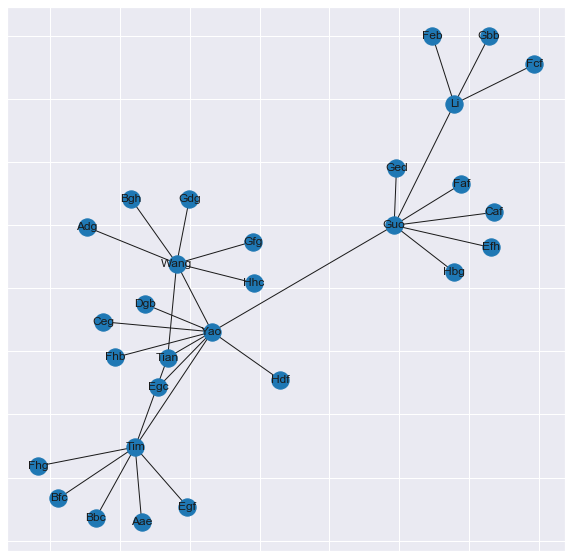

In [22]:
plt.figure(figsize=(10,10))
nx.draw_networkx(social_nx)
plt.show()

In [23]:
ranking_result = nx.pagerank(social_nx)

In [24]:
sorted(ranking_result.items(), key=lambda x: x[1], reverse=1)

[('Yao', 0.13267327585239913),
 ('Guo', 0.11272967851307805),
 ('Wang', 0.10768428320851282),
 ('Tim', 0.10768428320851282),
 ('Li', 0.06995860174040319),
 ('Tian', 0.04385427182289368),
 ('Fcf', 0.020039282976635146),
 ('Gbb', 0.020039282976635146),
 ('Feb', 0.020039282976635146),
 ('Faf', 0.018860451935758374),
 ('Efh', 0.018860451935758374),
 ('Caf', 0.018860451935758374),
 ('Ged', 0.018860451935758374),
 ('Hbg', 0.018860451935758374),
 ('Gdg', 0.0182480638615638),
 ('Bgh', 0.0182480638615638),
 ('Hhc', 0.0182480638615638),
 ('Adg', 0.0182480638615638),
 ('Gfg', 0.0182480638615638),
 ('Fhg', 0.0182480638615638),
 ('Bbc', 0.0182480638615638),
 ('Egf', 0.0182480638615638),
 ('Bfc', 0.0182480638615638),
 ('Aae', 0.0182480638615638),
 ('Hdf', 0.01770297168597297),
 ('Dgb', 0.01770297168597297),
 ('Egc', 0.01770297168597297),
 ('Ceg', 0.01770297168597297),
 ('Fhb', 0.01770297168597297)]

## TextRank（抽取式摘要）
两个应用
- 从句子中抽取句子关键词
    - 句子分词，用名词或者动词作为图结点，使用共现矩阵进行边构建
    - 使用page算法排序，取前N位进行组合后为句子关键字
- 从文档中抽取文档摘要（句子）
    - 文档分句，用单句作为图结点，句间相似度进行边构建
        - 相似度方法：
            - TextRank论文采用公式
            - StringKernel
            - 余弦距离
            - 编辑距离（最长公共子串）
    - 同上方式取若干句作为文档摘要

In [1]:
for x in df_clean.content[:10]:
    print(x)

NameError: name 'df_clean' is not defined